# Brain Tumor Classification Using a Convolutional Nerual Network (CNN)

## Project Overview
This project aims to develop a Convolutional Nerual Network (CNN) to classify brain tumors using medical imaging data. My focus is to leverage deep learning techniques to create an accurate and efficient model for the purpose of identifying tumor types, which can have significant implications in healthcare.

## Motivation
I embarked on this project due to my strong interest in applying **machine learning in the field of healthcare**. This field holds immense potential for improving patient care and overall diagnostics. Additionally, I wanted to:
- Gain hands-on experience with both **TensorFlow** and **Keras**, both of which I haven't used before.
- Strengthen my understanding of **neural network architectures**, specifically CNNs.
- Apply machine learning to a practical problem with potential real-world impact.

## Goals and Objectives
My primary objectives with this project are to:
1. **Build a CNN model** used for classifying brain tumors
2. **Learn and practice** using TensorFlow and Keras libraries
3. **Evaluate** a model's performance using appropriate metrics, and optimize it for a higher accuracy
4. **Explore potential real-world challenges** and applications of machine learning in the field of healthcare.

In [2]:
# Verify we are using tensorflow-gpu
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [3]:
# All imports used
import os
import cv2
import numpy as np
import tqdm
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import clone_model

Initially when I started this project I hadn't setup my JupyterLab environment to run off my GPU, and in the meantime was using Google Colab to facilitate my needs. These next three blocks are if you are loading the files through Google Colab and need access through Google Drive

In [ ]:
# Mount Google Drive to gain access to files within zip folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read/Load Training Files for Colab
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Training.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/tmp') #Extracts the files into the /tmp folder
zip_train.close()

In [ ]:
# Divide our train-test data
train_path = "/tmp/Training"
test_path = "/tmp/Testing"

If you're not using Google Colab, use the code block below to load the data based on the uploaded file names in a platform like JupyterLab. Modify it as needed.

In [4]:
base_path = "./Data"
train_path = os.path.join(base_path, "Training")
test_path = os.path.join(base_path, "Testing")

In [5]:
# Function to iterate through desired path/folders to read/load in image data
def load_data(data_dir):
    images = []
    labels = []
    classes = os.listdir(data_dir)

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                images.append(img)
                labels.append(class_idx)

    return images, labels

X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

In [6]:
print(len(y_train))
print(len(X_train))

2870
2870


The first step in preprocessing the data is to check the dimensions of the loaded image datasets. Since I know the images in this dataset vary in size, it is essential to identify the most common dimensions. This allows us to determine what the appropriate uniform size is to which all the images can be resized, ensuring uniform consistency and compatibility for the CNN input.

In [7]:
# Function to check dimensions of loaded image data
def check_sizes(data):
    data_shapes = [img.shape for img in data]
    shape_counts = Counter(data_shapes)
    sorted_shapes = shape_counts.most_common(10)
    return sorted_shapes

In [8]:
# Find most common image dimensions for resizing
print("Most frequent Train image shapes:")
for shape, count in check_sizes(X_train):
  print(f"- {shape}: {count}")

Most frequent Train image shapes:
- (512, 512, 3): 2309
- (236, 236, 3): 46
- (225, 225, 3): 30
- (442, 442, 3): 15
- (256, 256, 3): 15
- (630, 630, 3): 14
- (350, 350, 3): 10
- (251, 201, 3): 8
- (251, 236, 3): 4
- (260, 236, 3): 4


We can see that there are a wide variety of image dimensions, so finding a uniform size will be essential to enhance the efficiency of the model. Additionally, we can also see that some image dimensions are not square. It may be interesting to test whether adding padding during resizing impacts the models performance. To investigate this, I will create two testing and training datasets, resizing the images both with and without padding, to determine whether padding affects the model's efficiency.

First we'll create our function to add padding to the images, then create train and test data resized to a uniform size (225x225 px)

In [9]:
# Function to resize while adding padding to images
def resize_with_padding(image, target_size=(225, 225)):
    # Original dimensions of image
    height, width, _ = image.shape

    # Original aspect ratio of image
    aspect_ratio = width / height

    # Resize the image to fit the target_size, while maintaining aspect ratio
    if aspect_ratio > 1: # If wider than tall
        new_width = target_size[0]
        new_height = int(target_size[0] / aspect_ratio)
        # If new_height exceeds target_size[1], adjust width
        if new_height > target_size[1]:
            new_height = target_size[1]
            new_width = int(target_size[1] * aspect_ratio)
    else: # If taller than wide
        new_height = target_size[1]
        new_width = int(target_size[1] * aspect_ratio)
        # If new_width exceeds target_size[0], adjust height
        if new_width > target_size[0]:
            new_width = target_size[0]
            new_height = int(target_size[0] / aspect_ratio)

    # Resize image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Ensure resized image does not exceed target_size
    resized_image = cv2.resize(resized_image, (min(new_width, target_size[0]), min(new_height, target_size[1])))

    # Create blank image of target size (filled with black)
    padded_image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

    # Calculate padding
    start_x = (target_size[0] - new_width) // 2
    start_y = (target_size[1] - new_height) // 2

    # Place resized image in the center of padded image
    padded_image[start_y:start_y + new_height, start_x:start_x + new_width] = resized_image

    return padded_image

# Resize images to uniform size WITH PADDING
padded_X_train = [resize_with_padding(img) for img in X_train]
padded_X_test = [resize_with_padding(img) for img in X_test]

Next, we'll create train and test data where we resize our data to a uniform size (225x225 px) without repadding

In [10]:
# Resize images to uniform size WITHOUT PADDING
unpadded_X_train = [cv2.resize(img, (225,225)) for img in X_train]
unpadded_X_test = [cv2.resize(img, (225,225)) for img in X_test]

We can now verify that all the images have been correctly resized to consistent dimensions.

In [11]:
# Verify images are resized properly
print("Most frequent Train image shapes (with padding):")
for shape, count in check_sizes(padded_X_train):
  print(f"- {shape}: {count}\n")

print("Most frequent Train image shapes (no padding):")
for shape, count in check_sizes(unpadded_X_train):
  print(f"- {shape}: {count}")

Most frequent Train image shapes (with padding):
- (225, 225, 3): 2870

Most frequent Train image shapes (no padding):
- (225, 225, 3): 2870


In [12]:
print(len(padded_X_train))
print(len(padded_X_test))
print(len(unpadded_X_train))
print(len(unpadded_X_test))

2870
394
2870
394


In [13]:
# Data processing for images WITH PADDING
padded_X_train = np.array(padded_X_train)
y_train_padded = np.array(y_train)

# Shuffle data
padded_X_train, y_train_padded = shuffle(padded_X_train, y_train_padded, random_state=84)

# Split into training, validation, and test sets
padded_X_train, padded_X_test, y_train_padded, y_test_padded = train_test_split(padded_X_train, y_train_padded, test_size=0.1, random_state=42)
padded_X_train, padded_X_val, y_train_padded, y_val_padded = train_test_split(padded_X_train, y_train_padded, test_size=0.1, random_state=42)

In [14]:
print(len(padded_X_train))  # Should match len(y_train_padded)
print(len(y_train_padded))  # Should match len(unpadded_X_train)

2324
2324


In [15]:
# Data processing for images WITHOUT PADDING
unpadded_X_train = np.array(unpadded_X_train)
y_train_unpadded = np.array(y_train)

# Shuffle data
unpadded_X_train, y_train_unpadded = shuffle(unpadded_X_train, y_train_unpadded, random_state=84)

# Split into training, validation, and test sets
unpadded_X_train, unpadded_X_test, y_train_unpadded, y_test_unpadded = train_test_split(unpadded_X_train, y_train_unpadded, test_size=0.1, random_state=42)
unpadded_X_train, unpadded_X_val, y_train_unpadded, y_val_unpadded = train_test_split(unpadded_X_train, y_train_unpadded, test_size=0.1, random_state=42)

In [16]:
print(len(unpadded_X_train))  # Should match len(y_train_unpadded)
print(len(y_train_unpadded))  # Should match len(unpadded_X_train)

2324
2324


In [17]:
# Apply to_categorical to padded data
y_train_padded = to_categorical(y_train_padded)
y_val_padded = to_categorical(y_val_padded)
y_test_padded = to_categorical(y_test_padded)

# Apply to_categorical to unpadded data
y_train_unpadded = to_categorical(y_train_unpadded)
y_val_unpadded = to_categorical(y_val_unpadded)
y_test_unpadded = to_categorical(y_test_unpadded)

In [18]:
model1 = Sequential([
    Conv2D(32, (3,3), 1, activation='relu', input_shape=(225,225,3)),
    Conv2D(64, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(64, (3,3), 1, activation='relu'),
    Conv2D(64, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), 1, activation='relu'),
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), 1, activation='relu'),
    Conv2D(256, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 221, 221, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0

In [20]:
padded_model1 = clone_model(model1)
padded_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
padded_model1_history = padded_model1.fit(padded_X_train, y_train_padded, epochs=15, validation_data=(padded_X_val, y_val_padded), shuffle=True)

Epoch 1/15
73/73 [==============================] - 23s 158ms/step - loss: 10.2412 - accuracy: 0.3156 - val_loss: 1.0782 - val_accuracy: 0.5212
Epoch 2/15
73/73 [==============================] - 6s 81ms/step - loss: 1.0532 - accuracy: 0.5738 - val_loss: 0.8859 - val_accuracy: 0.5985
Epoch 3/15
73/73 [==============================] - 6s 81ms/step - loss: 0.8444 - accuracy: 0.6555 - val_loss: 0.8389 - val_accuracy: 0.6718
Epoch 4/15
73/73 [==============================] - 6s 82ms/step - loss: 0.7396 - accuracy: 0.6855 - val_loss: 0.7596 - val_accuracy: 0.6873
Epoch 5/15
73/73 [==============================] - 6s 82ms/step - loss: 0.7038 - accuracy: 0.7158 - val_loss: 0.7166 - val_accuracy: 0.7297
Epoch 6/15
73/73 [==============================] - 6s 82ms/step - loss: 0.5941 - accuracy: 0.7489 - val_loss: 0.6291 - val_accuracy: 0.7027
Epoch 7/15
73/73 [==============================] - 6s 82ms/step - loss: 0.5394 - accuracy: 0.8004 - val_loss: 0.5847 - val_accuracy: 0.7606
Epoch 8/15

In [21]:
unpadded_model1 = clone_model(model1)
unpadded_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unpadded_model1_history = unpadded_model1.fit(unpadded_X_train, y_train_unpadded, epochs=15, validation_data=(unpadded_X_val, y_val_unpadded), shuffle=True)

Epoch 1/15
73/73 [==============================] - 7s 84ms/step - loss: 8.2014 - accuracy: 0.3052 - val_loss: 1.0155 - val_accuracy: 0.4865
Epoch 2/15
73/73 [==============================] - 6s 82ms/step - loss: 1.0318 - accuracy: 0.5491 - val_loss: 0.8505 - val_accuracy: 0.6216
Epoch 3/15
73/73 [==============================] - 6s 82ms/step - loss: 0.8195 - accuracy: 0.6359 - val_loss: 0.7866 - val_accuracy: 0.6834
Epoch 4/15
73/73 [==============================] - 6s 82ms/step - loss: 0.7002 - accuracy: 0.7252 - val_loss: 0.7403 - val_accuracy: 0.7066
Epoch 5/15
73/73 [==============================] - 6s 82ms/step - loss: 0.5946 - accuracy: 0.7684 - val_loss: 0.6276 - val_accuracy: 0.7722
Epoch 6/15
73/73 [==============================] - 6s 82ms/step - loss: 0.5399 - accuracy: 0.7859 - val_loss: 0.5573 - val_accuracy: 0.7375
Epoch 7/15
73/73 [==============================] - 6s 83ms/step - loss: 0.4791 - accuracy: 0.8118 - val_loss: 0.4114 - val_accuracy: 0.8494
Epoch 8/15
73

In [22]:
# Function to plot history of the model and determine best iterations
def plot_model_history(model, padding):
    # Retrieve training and validation metrics from the model history
    trn_acc = model.history['accuracy']  # Training accuracy
    trn_loss = model.history['loss']  # Training loss
    val_acc = model.history['val_accuracy']  # Validation accuracy
    val_loss = model.history['val_loss']  # Validation loss

    # Find the best epochs in terms of loss and accuracy
    index_loss = np.argmin(val_loss)  # Index of the lowest validation loss
    val_lowest = val_loss[index_loss]  # Value of the lowest validation loss
    index_acc = np.argmax(val_acc)  # Index of the highest validation accuracy
    acc_highest = val_acc[index_acc]  # Value of the highest validation accuracy

    # List of epochs
    Epochs = [i + 1 for i in range(len(trn_acc))]  # List of epochs from 1 to N
    loss_label = f'Best epoch = {str(index_loss + 1)}'  # Label for the best epoch for loss
    acc_label = f'Best epoch = {str(index_acc + 1)}'  # Label for the best epoch for accuracy

    # Configure the figure to display the graphs
    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')  # Use a predefined style for the graphs

    # First subplot: Training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, trn_loss, 'r', label='Training loss')  # Training loss curve
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')  # Validation loss curve
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Mark the best epoch for loss
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Second subplot: Training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, trn_acc, 'r', label='Training Accuracy')  # Training accuracy curve
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')  # Validation accuracy curve
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Mark the best epoch for accuracy
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    if padding == True:
        is_padded = '(with Padding)'
    else:
        is_padded = '(without Padding)'

    # Display the figure with subplots
    plt.suptitle(f'Model Training Metrics Over Epochs {is_padded}', fontsize=16)  # Overall title of the figure
    plt.show()

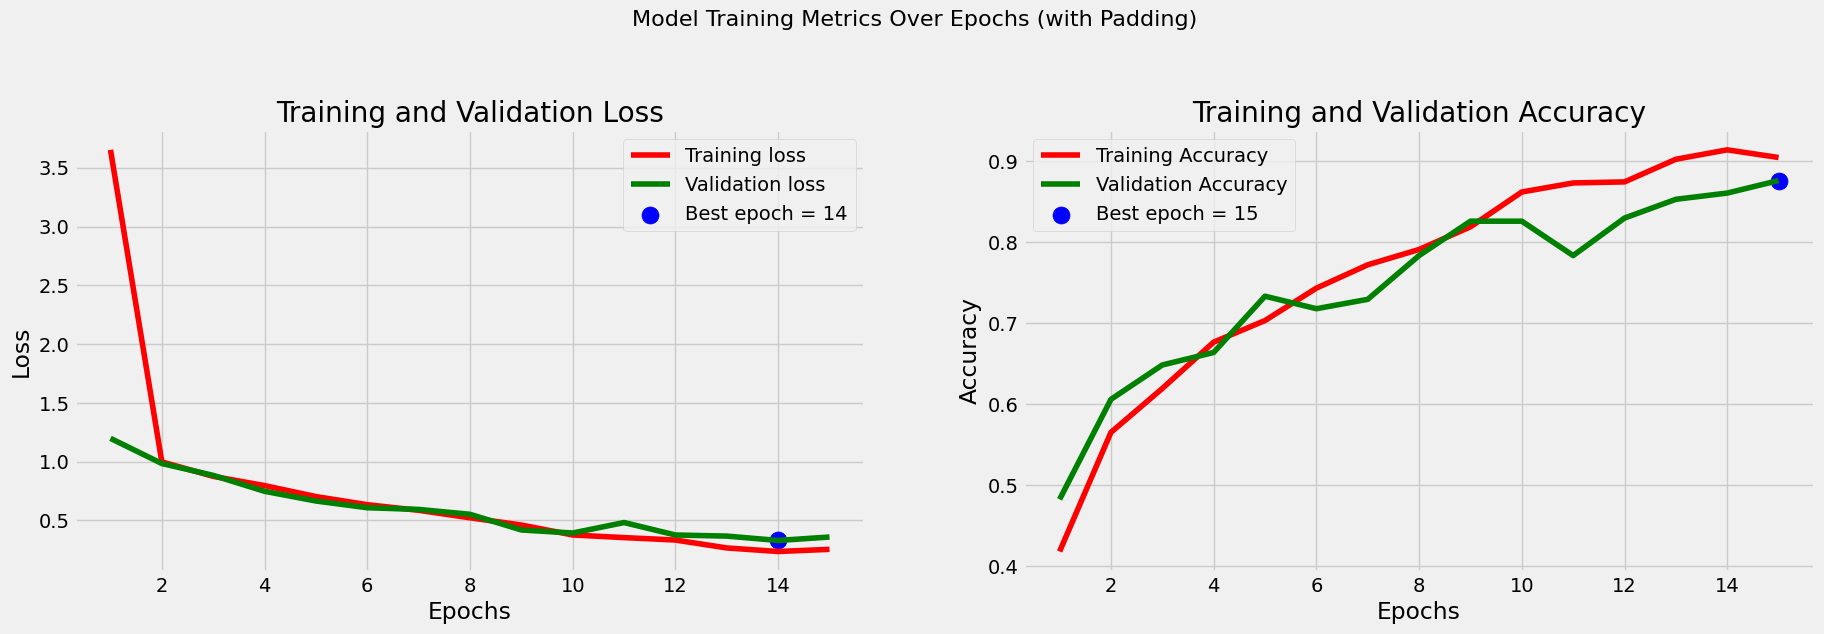

In [290]:
plot_model_history(padded_model1_history, True)

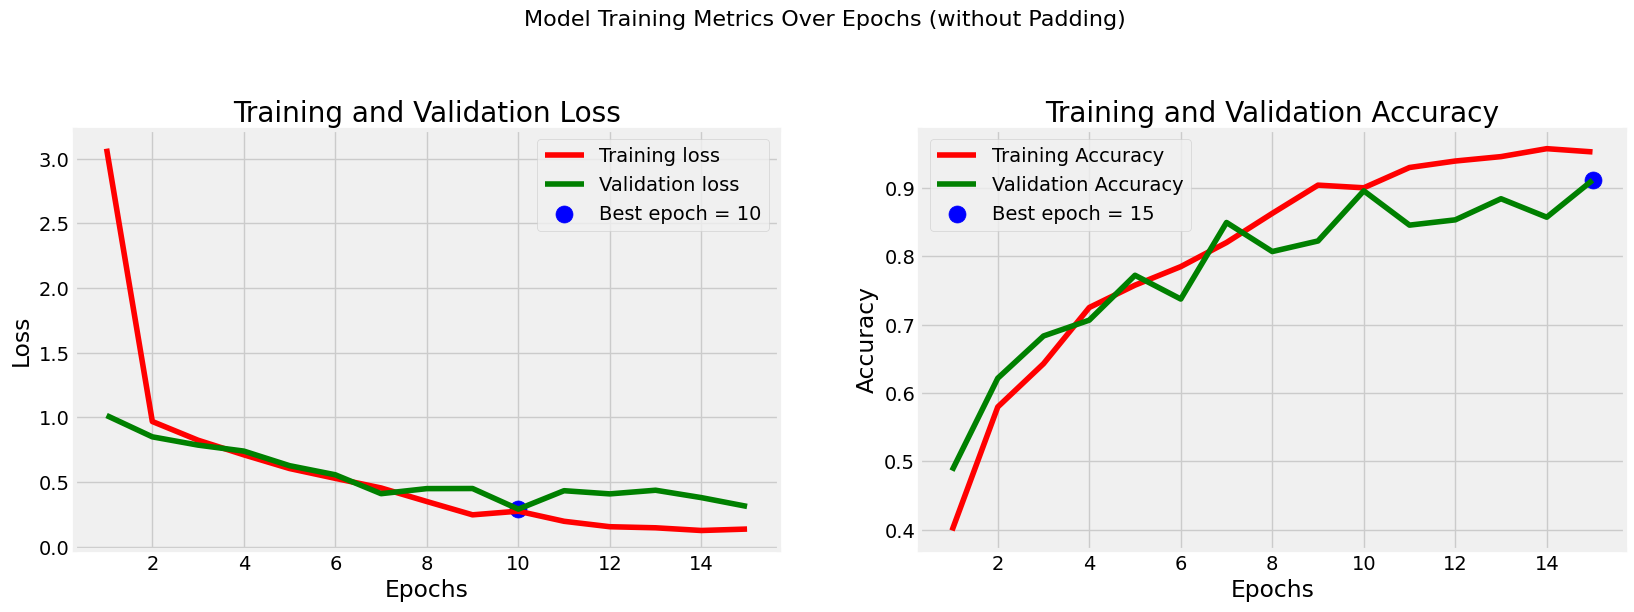

In [23]:
plot_model_history(unpadded_model1_history, False)

In [24]:
model2 = Sequential([
    Conv2D(64, (3,3), 1, activation='relu', input_shape=(225,225,3)),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(256, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(256, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(512, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 223, 223, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 128)      

In [27]:
padded_model2 = clone_model(model2)
padded_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
padded_model2_history = padded_model2.fit(padded_X_train, y_train_padded, epochs=40, validation_data=(padded_X_val, y_val_padded), shuffle=True)

Epoch 1/40
73/73 [==============================] - 18s 163ms/step - loss: 8.2524 - accuracy: 0.2714 - val_loss: 1.3556 - val_accuracy: 0.4556
Epoch 2/40
73/73 [==============================] - 5s 67ms/step - loss: 1.3003 - accuracy: 0.3705 - val_loss: 1.1676 - val_accuracy: 0.4788
Epoch 3/40
73/73 [==============================] - 5s 69ms/step - loss: 1.1485 - accuracy: 0.4926 - val_loss: 1.1876 - val_accuracy: 0.4826
Epoch 4/40
73/73 [==============================] - 5s 68ms/step - loss: 1.0534 - accuracy: 0.5496 - val_loss: 1.1780 - val_accuracy: 0.5058
Epoch 5/40
73/73 [==============================] - 5s 68ms/step - loss: 1.0063 - accuracy: 0.5610 - val_loss: 0.9642 - val_accuracy: 0.5792
Epoch 6/40
73/73 [==============================] - 5s 68ms/step - loss: 0.9769 - accuracy: 0.5728 - val_loss: 0.9506 - val_accuracy: 0.5637
Epoch 7/40
73/73 [==============================] - 5s 68ms/step - loss: 0.8436 - accuracy: 0.6435 - val_loss: 0.9637 - val_accuracy: 0.5676
Epoch 8/40


In [28]:
unpadded_model2 = clone_model(model2)
unpadded_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unpadded_model2_history = unpadded_model2.fit(unpadded_X_train, y_train_unpadded, epochs=40, validation_data=(unpadded_X_val, y_val_unpadded), shuffle=True)

Epoch 1/40
73/73 [==============================] - 12s 154ms/step - loss: 12.4205 - accuracy: 0.3075 - val_loss: 1.3637 - val_accuracy: 0.2896
Epoch 2/40
73/73 [==============================] - 7s 95ms/step - loss: 1.3291 - accuracy: 0.3332 - val_loss: 1.2264 - val_accuracy: 0.4981
Epoch 3/40
73/73 [==============================] - 6s 89ms/step - loss: 1.1596 - accuracy: 0.4877 - val_loss: 1.1207 - val_accuracy: 0.5058
Epoch 4/40
73/73 [==============================] - 11s 150ms/step - loss: 1.0722 - accuracy: 0.5290 - val_loss: 1.1320 - val_accuracy: 0.5097
Epoch 5/40
73/73 [==============================] - 8s 110ms/step - loss: 1.0071 - accuracy: 0.5676 - val_loss: 1.0158 - val_accuracy: 0.5290
Epoch 6/40
73/73 [==============================] - 7s 91ms/step - loss: 0.9739 - accuracy: 0.5783 - val_loss: 1.0769 - val_accuracy: 0.5367
Epoch 7/40
73/73 [==============================] - 12s 170ms/step - loss: 0.8655 - accuracy: 0.6308 - val_loss: 0.8067 - val_accuracy: 0.6641
Epoch

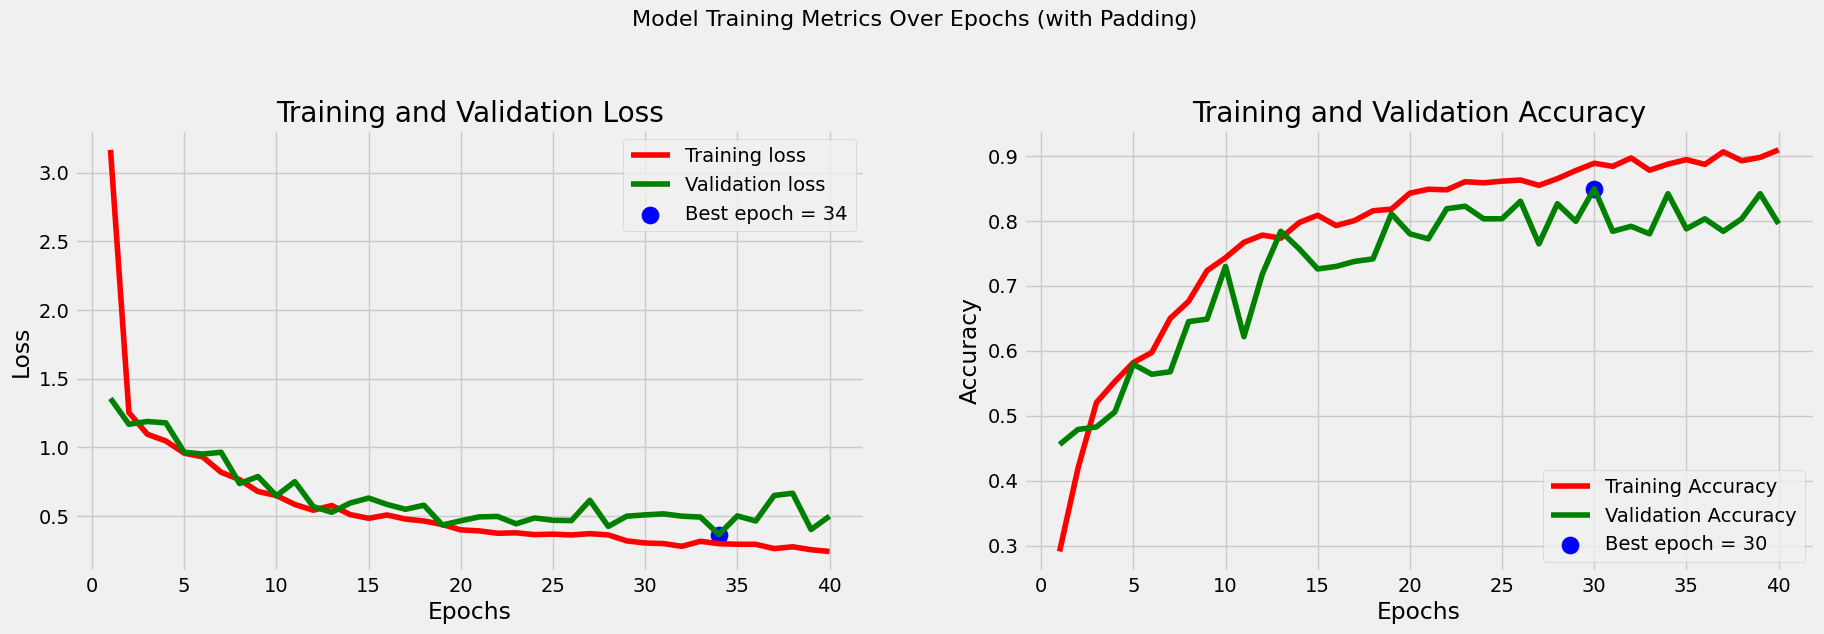

In [30]:
plot_model_history(padded_model2_history, True)

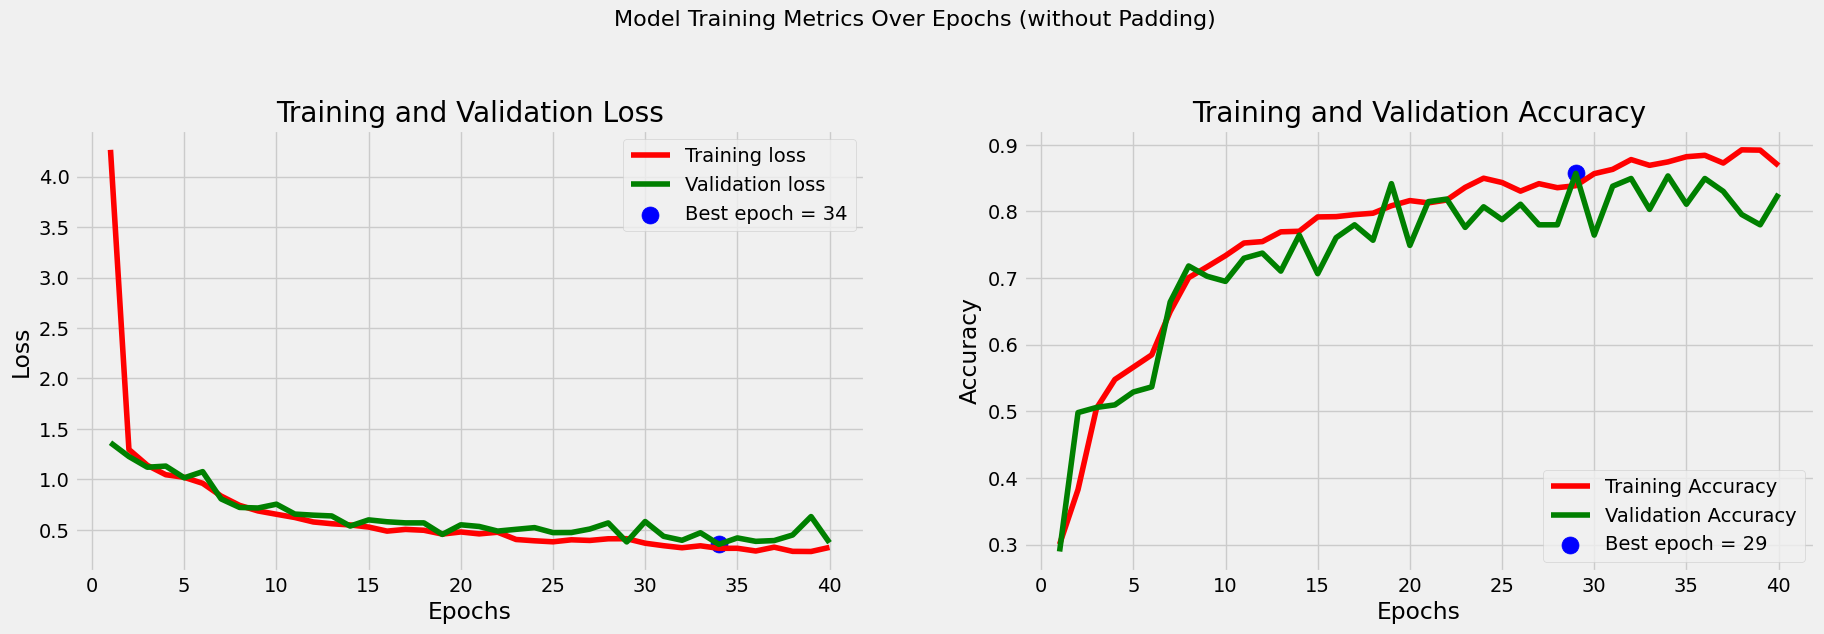

In [31]:
plot_model_history(unpadded_model2_history, False)

In [ ]:
model3 = Sequential([
    Conv2D(64, (3,3), 1, activation='relu', input_shape=(225,225,3)),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(256, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(256, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(512, (3,3), 1, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

In [ ]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model3_history = model3.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/40
73/73 [==============================] - 15s 176ms/step - loss: 4.2161 - accuracy: 0.3619 - val_loss: 1.2001 - val_accuracy: 0.4633
Epoch 2/40
73/73 [==============================] - 13s 172ms/step - loss: 1.0681 - accuracy: 0.5417 - val_loss: 1.0137 - val_accuracy: 0.5444
Epoch 3/40
73/73 [==============================] - 13s 173ms/step - loss: 0.9287 - accuracy: 0.5972 - val_loss: 1.0208 - val_accuracy: 0.5753
Epoch 4/40
73/73 [==============================] - 13s 172ms/step - loss: 0.8696 - accuracy: 0.6226 - val_loss: 0.8539 - val_accuracy: 0.5946
Epoch 5/40
73/73 [==============================] - 12s 169ms/step - loss: 0.6921 - accuracy: 0.7173 - val_loss: 0.7610 - val_accuracy: 0.7066
Epoch 6/40
73/73 [==============================] - 12s 170ms/step - loss: 0.6735 - accuracy: 0.7302 - val_loss: 0.6986 - val_accuracy: 0.7413
Epoch 7/40
73/73 [==============================] - 12s 169ms/step - loss: 0.6088 - accuracy: 0.7423 - val_loss: 0.7464 - val_accuracy: 0.7220

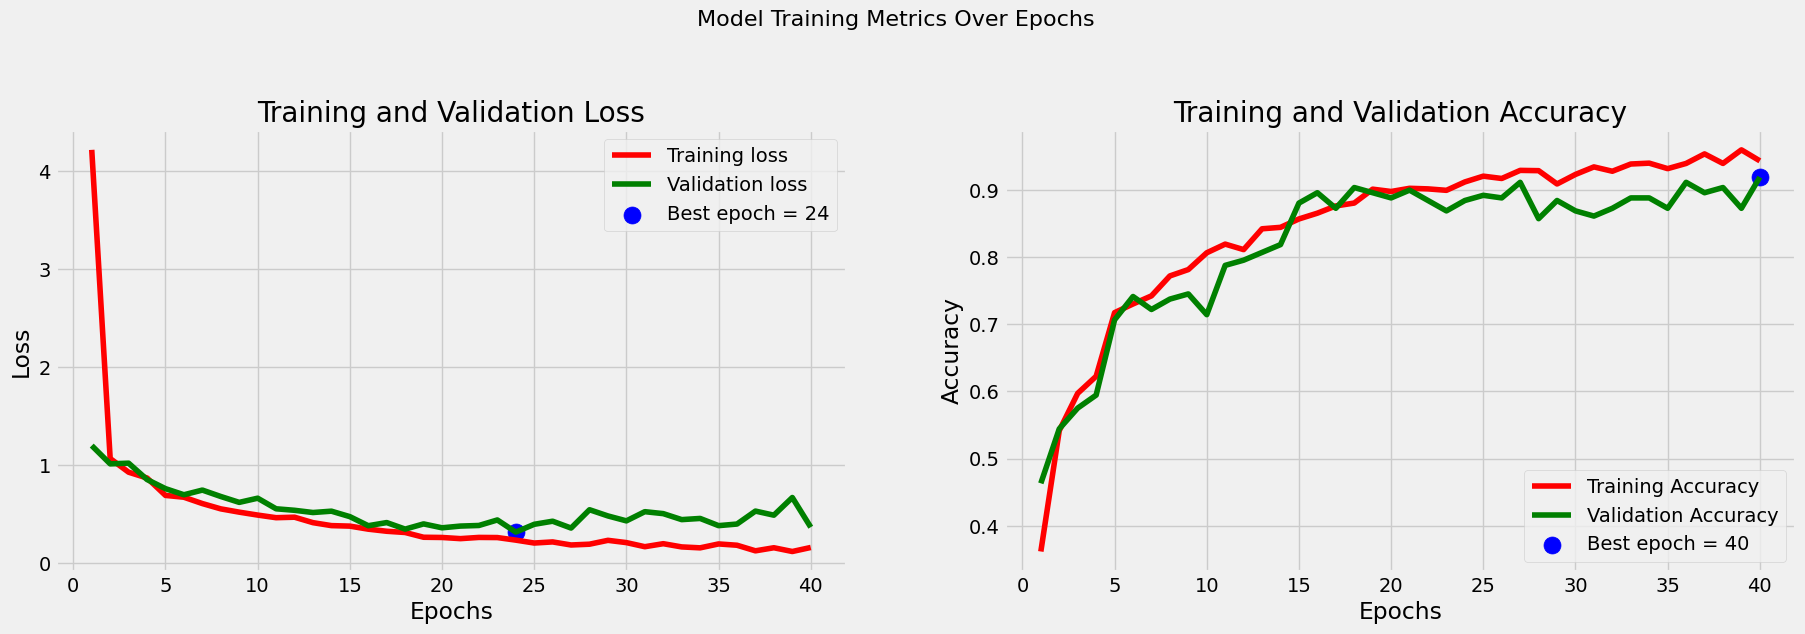

In [ ]:
plot_model_history(model3_history)